# <span style="color:yellow">New Classes and Some Functions</span>

In [1]:
from TMclass import *
import datetime
fromiso = datetime.datetime.fromisoformat
tdelta = datetime.timedelta
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from xml.etree import ElementTree


def flush_many(max_vol, vol_dataset, phi_mode, start, nbits, ndata, level, partition):
    global PHI
    global phi

    def _new_start(start,end):
        start += datetime.timedelta(days=1)
        start = start.replace(hour=3,minute=0,second=0)
        if end > start:
            start = end + datetime.timedelta(hours=1)
        return start
    

    vol0 = max_vol[0]
    vol1 = max_vol[1]
    n0 = int(vol0 // vol_dataset * 0.99)
    n1 = int(vol1 // vol_dataset * 0.99)

    if ndata == -1:
        ndata = phi_mode.raw.n_datasets
    
    print(f'Days needed: {(ndata-n0)//n1+2}')
    kw = phi_mode.compressing(start, nbits = nbits, ndata = n0,level=level); phi.saving(partition,**kw); PHI.saving(partition,**kw)
    # start += datetime.timedelta(days=1)
    start = _new_start(start,kw['end'])

    for i in range((ndata-n0)//n1+1):
        kw = phi_mode.compressing(start, nbits = nbits, ndata = n1,level=level); phi.saving(partition,**kw); PHI.saving(partition,**kw)
        start = _new_start(start,kw['end'])

    return (phi_mode, kw)

PHI = PHI_MEMORY(datetime.datetime.fromisoformat('2022-01-19T23:00:00'))

TM = {'date':[], 'tm_rate':[], 'duration':[]}
TMnew = {'date':[], 'tm_rate':[], 'duration':[]}

with open('../telem.xml') as f:
    tree = ElementTree.parse(f)

for node in tree.iter('PASS'):
    d = datetime.datetime.fromisoformat(node.attrib.get('comment')[:-1]).date()
    if d >= datetime.date(2022,1,1) and d <= datetime.date(2023,1,1):
        TM['date'] += [datetime.datetime.fromisoformat(node.attrib.get('comment')[:-1])]
        TM['tm_rate'] += [float(node.attrib.get('tm_rate'))]
        TM['duration'] += [int(node.attrib.get('duration'))]

with open('../EFECS_M06_V00.xml') as f:
    tree = ElementTree.parse(f)

for node in tree.iter('PASS'):
    d = datetime.datetime.strptime(node.attrib.get('time')[:-1],"%Y-%jT%H:%M:%S").date()
    if d >= datetime.date(2022,1,1) and d <= datetime.date(2023,1,1):
        TMnew['date'] += [datetime.datetime.strptime(node.attrib.get('time')[:-1],"%Y-%jT%H:%M:%S")]
        TMnew['tm_rate'] += [float(node.attrib.get('tm_rate'))]
        TMnew['duration'] += [int(node.attrib.get('duration'))]

TM['date'] = np.asarray(TM['date'])
TM['tm_rate'] = np.asarray(TM['tm_rate'])
TM['duration'] = np.asarray(TM['duration'])

TMnew['date'] = np.asarray(TMnew['date'])
TMnew['tm_rate'] = np.asarray(TMnew['tm_rate'])
TMnew['duration'] = np.asarray(TMnew['duration'])

f = open('phi.itl','r')
lines = f.readlines()

FL = {'date':[], 'flush':[]}

for x in lines:
    temp = x.split(' ')
    if 'PHI_SCI_Flush_VOL' in temp[-1]:
        FL['date'] += [datetime.datetime.fromisoformat(temp[0][:-1])]
        FL['flush'] += [float(temp[-1][19:-2])]
        # print(temp[0][:-1],temp[-1][19:-2])

FL['date'] = np.asarray(FL['date'])
FL['flush'] = np.asarray(FL['flush'])

f = open('phi.itl','r')
lines = f.readlines()

# SV = {'date':[], 'rate':[]}

# for x in lines:
#     temp = x.split(' ')
#     if 'PHI_SCI_Rate' in temp[-1]:
#         SV['date'] += [datetime.datetime.fromisoformat(temp[0][:-1])]
#         SV['rate'] += [float(temp[-1][14:-2])]
#         # print(temp[0][:-1],temp[-1][19:-2])

# SV['date'] = np.asarray(SV['date'])
# SV['rate'] = np.asarray(SV['rate'])

f = open('phi_new.itl','r')
lines = f.readlines()

FLnew = {'date':[], 'flush':[]}

for x in lines:
    temp = x.split(' ')
    if 'PHI_SCI_Flush_VOL' in temp[-1]:
        FLnew['date'] += [datetime.datetime.fromisoformat(temp[0][:-1])]
        FLnew['flush'] += [float(temp[-1][19:-2])]
        # print(temp[0][:-1],temp[-1][19:-2])

FLnew['date'] = np.asarray(FLnew['date'])
FLnew['flush'] = np.asarray(FLnew['flush'])



In [2]:
def syn_crop(rsyn_list,crpk_list,t0,ndata,rcrop,hcrop):
    global PHI
    rsyn = rsyn_list[0]
    ir = rsyn_list[1]
    crpk = crpk_list[0]
    ic = crpk_list[1]
    kw = rsyn.observation(t0,1,cadence=120,shape=(2048,rcrop,4,6)); PHI.saving(ir,**kw)
    ti = t0 + tdelta(minutes=5)
    if type(ndata) is int:
        kw = crpk.cropping(ti,ndata=ndata,crop=[hcrop,hcrop],level='raw'); PHI.saving(ic,**kw)
        kw = crpk.packing(kw['end'] + tdelta(minutes=2),ndata=ndata,level='raw.crop'); PHI.saving(ic,**kw)
        print(f'end of packing and cropping of {crpk.raw.pack.n_datasets}/{crpk.raw.n_datasets} datasets: '+kw['end'].isoformat().split('.')[0])

    else:
        for i,n in enumerate(ndata):
            if len(crpk_list)>2:
                crpk = crpk_list[2*i]
                ic = crpk_list[2*i+1]
            kw = crpk.cropping(ti + tdelta(minutes=2),ndata=n,crop=[hcrop,hcrop],level='raw'); PHI.saving(ic,**kw)
            kw = crpk.packing(kw['end'] + tdelta(minutes=2),ndata=n,level='raw.crop'); PHI.saving(ic,**kw)
            ti = kw['end'] + tdelta(minutes=2)
            print(f'end of packing and cropping of {crpk.raw.pack.n_datasets}/{crpk.raw.n_datasets} datasets: '+kw['end'].isoformat().split('.')[0])

def syn(rsyn_list,fl_list,t0,ndata,rcrop,hcrop):
    global PHI
    rsyn = rsyn_list[0]
    ir = rsyn_list[1]
    fl = fl_list[0]
    il = fl_list[1]
    kw = rsyn.observation(t0,1,cadence=120,shape=(2048,rcrop,4,6)); PHI.saving(ir,**kw)
    ti = t0 + tdelta(minutes=5)
#     kw = rsyn.cropping(ti,ndata=1,crop=[rcrop,rcrop],level='raw'); PHI.saving(ir,**kw)
#     kw = rsyn.packing(kw['end'] + tdelta(minutes=5),ndata=1,level='raw.crop'); PHI.saving(ir,**kw)
#     print(f'end of packing and cropping of {rsyn.raw.pack.this_run} datasets: '+kw['end'].isoformat().split('.')[0])
    kw = rsyn.compressing(ti, nbits = 6, ndata = 12,level='raw.pack'); PHI.saving(ir,**kw)
    print(f'end of flushing {round(rsyn.compr.pack.data,0)} MB ({rsyn.compr.pack.this_run} datasets, {rsyn.compr.pack.n_datasets}/{rsyn.raw.n_datasets}): '+kw['end'].isoformat().split('.')[0])
    kw = fl.compressing(kw['end']+tdelta(minutes=5), nbits = 6, ndata = ndata,level='raw.pack'); PHI.saving(il,**kw)
    print(f'end of flushing {round(fl.compr.pack.data,0)} MB ({fl.compr.pack.this_run} datasets, {fl.compr.pack.n_datasets}/{fl.raw.n_datasets}): '+kw['end'].isoformat().split('.')[0])
    
def syn_flush(rsyn_list,fl_list,t0,ndata,rcrop,hcrop):
    global PHI
    rsyn = rsyn_list[0]
    ir = rsyn_list[1]
    fl = fl_list[0]
    il = fl_list[1]
    kw = rsyn.observation(t0,1,cadence=120,shape=(2048,rcrop,4,6)); PHI.saving(ir,**kw)
    ti = t0 + tdelta(minutes=5)
    if type(ndata) is int:
        kw = fl.compressing(ti, nbits = 6, ndata = ndata,level='raw.pack'); PHI.saving(il,**kw)
        print(f'end of flushing {round(fl.compr.pack.data,0)} MB ({fl.compr.pack.this_run} datasets, {fl.compr.pack.n_datasets}/{fl.raw.n_datasets}): '+kw['end'].isoformat().split('.')[0])
    else:
        kw = fl.compressing(ti, nbits = 6, ndata = ndata[0],level='raw.pack'); PHI.saving(il,**kw)
        print(f'end of flushing {round(fl.compr.pack.data,0)} MB ({fl.compr.pack.this_run} datasets, {fl.compr.pack.n_datasets}/{fl.raw.n_datasets}): '+kw['end'].isoformat().split('.')[0])
        fl = fl_list[2]
        il = fl_list[3]
        kw = fl.compressing(ti, nbits = 6, ndata = ndata[1],level='raw.pack'); PHI.saving(il,**kw)
        print(f'end of flushing {round(fl.compr.pack.data,0)} MB ({fl.compr.pack.this_run} datasets, {fl.compr.pack.n_datasets}/{fl.raw.n_datasets}): '+kw['end'].isoformat().split('.')[0])

def syn_flush_crop(rsyn_list,fl_list,t0,ndata,rcrop,hcrop):
    global PHI
    rsyn = rsyn_list[0]
    ir = rsyn_list[1]
    fl = fl_list[0]
    il = fl_list[1]
    crpk = fl_list[2]
    ic = fl_list[3]
    kw = rsyn.observation(t0,1,cadence=120,shape=(2048,rcrop,4,6)); PHI.saving(ir,**kw)
    ti = t0 + tdelta(minutes=5)
    kw = fl.compressing(ti, nbits = 6, ndata = ndata[0],level='raw.pack'); PHI.saving(il,**kw)
    print(f'end of flushing {round(fl.compr.pack.data,0)} MB ({fl.compr.pack.this_run} datasets, {fl.compr.pack.n_datasets}/{fl.raw.n_datasets}): '+kw['end'].isoformat().split('.')[0])
    if type(ndata[1]) is int:
        kw = crpk.cropping(ti,ndata=ndata[1],crop=[hcrop,hcrop],level='raw'); PHI.saving(ic,**kw)
        kw = crpk.packing(kw['end'] + tdelta(minutes=2),ndata=ndata[1],level='raw.crop'); PHI.saving(ic,**kw)
    else:
        for n in ndata[1]:
            kw = crpk.cropping(ti + tdelta(minutes=2),ndata=n,crop=[hcrop,hcrop],level='raw'); PHI.saving(ic,**kw)
            kw = crpk.packing(kw['end'] + tdelta(minutes=2),ndata=n,level='raw.crop'); PHI.saving(ic,**kw)
            ti = kw['end'] + tdelta(minutes=2)
    print(f'end of packing and cropping of {crpk.raw.pack.n_datasets}/{crpk.raw.n_datasets} datasets: '+kw['end'].isoformat().split('.')[0])

def print_flush_pack(mode):
    print(f'end of flushing {round(mode.compr.pack.data,0)} MB ({mode.compr.pack.this_run} datasets, {mode.compr.pack.n_datasets}/{mode.raw.n_datasets}): '+kw['end'].isoformat().split('.')[0])

def print_flush_proc(mode):
    print(f'end of flushing {round(mode.compr.data,0)} MB ({mode.compr.this_run} datasets, {mode.compr.n_datasets}/{mode.raw.n_datasets}): '+kw['end'].isoformat().split('.')[0])
   

# RSW

In [3]:
# PHI.format_partition(1,fromiso('2022-02-25T03:05:00'))
# PHI.format_partition(2,fromiso('2022-02-25T07:00:00'))
PHI = PHI_MEMORY(fromiso('2022-02-24T00:00:00'))

In [16]:
i = 1

t0 = fromiso('2022-03-03T09:40:00')
hrt_SW = PHI_MODE('HRT')
kw = hrt_SW.observation(t0,60*6,cadence=1,shape=(2048,2048,4,6)); PHI.saving(i,**kw) # should have been 20, but no time for flushing
kw = hrt_SW.processing(t0,ndata=1,partialStore=0,level='raw'); PHI.saving(i,**kw) # should have been 20, but no time for flushing

#kw = hrt_SW.cropping(fromiso('2022-03-03T18:05:00'),crop=[1024,1024],ndata=-1,level='raw'); PHI.saving(i,**kw)
#kw = hrt_SW.packing(fromiso('2022-03-03T19:05:00'),ndata=-1,level='raw.crop'); PHI.saving(i,**kw)


#kw = hrt_SW.compressing(fromiso('2022-03-03T19:35:00'),ndata=-1,nbits=6,level='raw.pack'); PHI.saving(i,**kw)
kw = hrt_SW.compressing(fromiso('2022-03-03T19:35:00'),ndata=-1,nbits=6,level='proc'); PHI.saving(i,**kw)
# kw = fdt_spice.compressing(kw['end'],ndata=-1,nbits=6,level='raw.pack'); PHI.saving(i,**kw)


In [19]:
print(hrt_SW.compr.data_tot*10**6/2**20)

15.429153442382814


In [11]:
print(PHI.part1.compr)
print(PHI.part1.occu)
print(hrt_SW.raw.crop.end - hrt_SW.raw.crop.start)
print(hrt_SW.raw.pack.end - hrt_SW.raw.pack.start)
print(hrt_SW.compr.pack.end - hrt_SW.compr.pack.start)

11330.0208
235200.0
4:27:06.480000
4:08:38.976000
15:06:24.099840


In [4]:
t0 = fromiso('2022-02-25T21:00:00')
# t1 = fromiso('2022-01-28T00:30:00')
i = 1

cad = 2

fdt_focus = PHI_MODE('FDT')
kw = fdt_focus.observation(t0,71,cadence=cad,shape=(2048,2048,1,1)); PHI.saving(i,**kw)

t0 = fromiso('2022-02-27T20:30:00')
fdt_one = PHI_MODE('FDT')
kw = fdt_one.observation(t0,1,cadence=cad,shape=(2048,1024,4,6)); PHI.saving(i,**kw)
kw = fdt_one.cropping(kw['end'],crop=[1024,1024],ndata=1,level='raw'); PHI.saving(i,**kw)
kw = fdt_one.processing(kw['end'],ndata=1,partialStore=0,level='raw.crop'); PHI.saving(i,**kw)

t0 = fromiso('2022-02-28T20:30:00')
kw = fdt_one.observation(t0,1,cadence=cad,shape=(2048,1024,4,6)); PHI.saving(i,**kw)
kw = fdt_one.cropping(kw['end'],crop=[1024,1024],ndata=1,level='raw'); PHI.saving(i,**kw)
kw = fdt_one.processing(kw['end'],ndata=1,partialStore=0,level='raw.crop'); PHI.saving(i,**kw)


t0 = fromiso('2022-03-01T10:30:00')
hrt_focus = PHI_MODE('HRT')
kw = hrt_focus.observation(t0,71,cadence=cad,shape=(2048,2048,1,1)); PHI.saving(i,**kw)


kw = fdt_one.packing(kw['end'],ndata=1,level='raw.crop'); PHI.saving(i,**kw)
kw = fdt_one.compressing(kw['end'],ndata=1,nbits=6,level='raw.pack'); PHI.saving(i,**kw)

t0 = fromiso('2022-03-01T20:30:00')
kw = fdt_one.observation(t0,1,cadence=cad,shape=(2048,1024,4,6)); PHI.saving(i,**kw)
kw = fdt_one.cropping(kw['end'],crop=[1024,1024],ndata=1,level='raw'); PHI.saving(i,**kw)
kw = fdt_one.processing(kw['end'],ndata=1,partialStore=0,level='raw.crop'); PHI.saving(i,**kw)

t0 = fromiso('2022-03-02T02:30:00')
fdt_spice = PHI_MODE('FDT')
kw = fdt_spice.observation(t0,4,cadence=6*60,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = fdt_spice.packing(kw['end'],ndata=1,level='raw'); PHI.saving(i,**kw)

t0 = fromiso('2022-03-03T00:30:00')
kw = fdt_focus.observation(t0,70,cadence=cad,shape=(2048,2048,1,1)); PHI.saving(i,**kw)

t0 = fromiso('2022-03-03T04:00:00')
fdt_flat = PHI_MODE('FDT')
kw = fdt_flat.observation(t0,10,cadence=6,shape=(2048,2048,4,6)); PHI.saving(i,**kw)



In [5]:
i = 1

t0 = fromiso('2022-03-03T09:40:00')
hrt_SW = PHI_MODE('HRT')
kw = hrt_SW.observation(t0,16,cadence=3,shape=(2048,2048,4,6)); PHI.saving(i,**kw) # should have been 20, but no time for flushing
kw = hrt_SW.packing(fromiso('2022-03-03T18:05:00'),ndata=-1,level='raw'); PHI.saving(i,**kw)


kw = hrt_SW.compressing(fromiso('2022-03-03T19:35:00'),ndata=-1,nbits=6,level='raw.pack'); PHI.saving(i,**kw)
kw = fdt_spice.compressing(kw['end'],ndata=-1,nbits=6,level='raw.pack'); PHI.saving(i,**kw)


In [6]:
i = 1

t0 = fromiso('2022-03-04T10:45:00')
hrt_SW = PHI_MODE('HRT')
kw = hrt_SW.observation(t0,19,cadence=3,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = hrt_SW.packing(fromiso('2022-03-04T18:05:00'),ndata=-1,level='raw'); PHI.saving(i,**kw)

kw = fdt_flat.packing(kw['end'],ndata=1,level='raw'); PHI.saving(i,**kw)

kw = hrt_SW.compressing(fromiso('2022-03-04T20:05:00'),ndata=-1,nbits=6,level='raw.pack'); PHI.saving(i,**kw)
kw = fdt_flat.compressing(kw['end'],ndata=1,nbits=6,level='raw.pack'); PHI.saving(i,**kw)

t0 = fromiso('2022-03-05T15:20:00')
hrt_SW = PHI_MODE('HRT')
kw = hrt_SW.observation(t0,20,cadence=3,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = hrt_SW.packing(fromiso('2022-03-05T18:05:00'),ndata=-1,level='raw'); PHI.saving(i,**kw)

kw = hrt_SW.compressing(fromiso('2022-03-05T20:05:00'),ndata=-1,nbits=6,level='raw.pack'); PHI.saving(i,**kw)


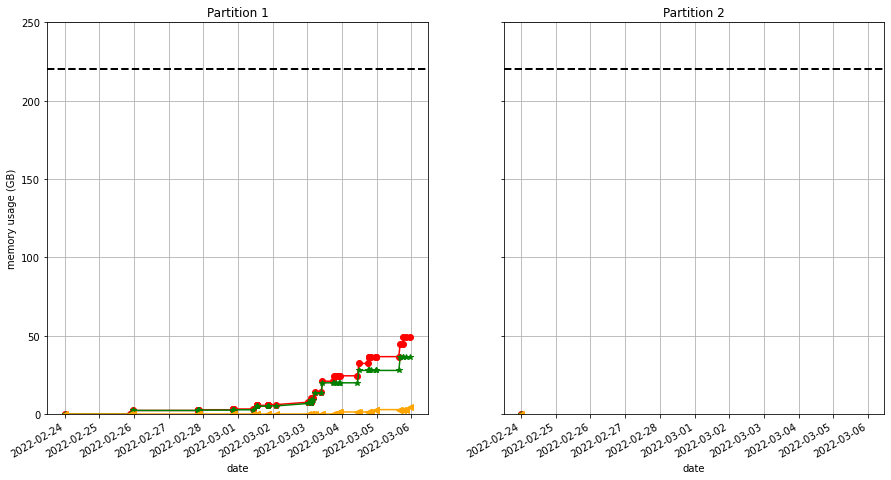

In [7]:
plot_tot(PHI)
PHI.format_partition(2,fromiso('2022-03-06T00:05:00'))
PHI.format_partition(1,fromiso('2022-03-06T03:20:00'))


In [8]:
i = 1

t0 = fromiso('2022-03-06T14:30:00')
hrt_focus = PHI_MODE('HRT')
kw = hrt_focus.observation(t0,71,cadence=1,shape=(2048,2048,1,1)); PHI.saving(i,**kw)

i = 2
t0 = fromiso('2022-03-06T17:20:00')
hrt_PO = PHI_MODE('HRT')
kw = hrt_PO.observation(t0,70,cadence=1,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = hrt_PO.packing(fromiso('2022-03-06T19:05:00'),ndata=-1,level='raw'); PHI.saving(i,**kw)
kw = hrt_PO.compressing(fromiso('2022-03-06T20:56:00'),nbits=6,ndata=9,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(hrt_PO)

i = 1
t0 = fromiso('2022-03-07T00:15:00')
hrt_focus = PHI_MODE('HRT')
kw = hrt_focus.observation(t0,40,cadence=1,shape=(2048,2048,1,1)); PHI.saving(i,**kw)

i = 1
t0 = fromiso('2022-03-07T01:10:00')
hrt_NF1 = PHI_MODE('HRT')
kw = hrt_NF1.observation(t0,90,cadence=1,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
hrt_PD1 = PHI_MODE('HRT')
kw = hrt_PD1.observation(kw['end'],1,cadence=1,shape=(2048,2048,1,2)); PHI.saving(i,**kw)
kw = hrt_NF1.packing(fromiso('2022-03-07T03:05:00'),ndata=-1,level='raw'); PHI.saving(i,**kw)
kw = hrt_PD1.packing(kw['end'],ndata=-1,level='raw'); PHI.saving(i,**kw)
# kw = hrt_NF1.compressing(fromiso('2022-03-06T21:05:00'),ndata=-1,level='raw'); PHI.saving(i,**kw)

i = 2

t0 = fromiso('2022-03-07T07:02:00')
hrt_CM = PHI_MODE('HRT')
kw = hrt_CM.observation(t0,25,cadence=10,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = hrt_CM.packing(fromiso('2022-03-07T12:05:00'),ndata=-1,level='raw'); PHI.saving(i,**kw)
# kw = hrt_CM.compressing(fromiso('2022-03-06T21:05:00'),ndata=-1,level='raw'); PHI.saving(i,**kw)

i=1
t0 = fromiso('2022-03-07T15:00:00')
hrt_focus = PHI_MODE('HRT')
kw = hrt_focus.observation(t0,40,cadence=1,shape=(2048,2048,1,1)); PHI.saving(i,**kw)

i = 2
t0 = fromiso('2022-03-07T16:01:00')
hrt_HE = PHI_MODE('HRT')
kw = hrt_HE.observation(t0,18,cadence=10,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
hrt_PD2 = PHI_MODE('HRT')
kw = hrt_PD2.observation(kw['end'],1,cadence=1,shape=(2048,2048,1,2)); PHI.saving(i,**kw)
kw = hrt_HE.packing(fromiso('2022-03-07T20:05:00'),ndata=-1,level='raw'); PHI.saving(i,**kw)
kw = hrt_PD2.packing(kw['end'],ndata=-1,level='raw'); PHI.saving(i,**kw)

# kw = hrt_HE.compressing(fromiso('2022-03-06T21:05:00'),ndata=-1,level='raw'); PHI.saving(i,**kw)

t0 = fromiso('2022-03-08T00:00:00')
hrt_NF2 = PHI_MODE('HRT')
kw = hrt_NF2.observation(t0,120,cadence=1,shape=(2048,2048,4,6)); PHI.saving(i,**kw)

t0 = fromiso('2022-03-08T07:00:00')
fdt_SP = PHI_MODE('FDT')
kw = fdt_SP.observation(t0,3,cadence=10,shape=(2048,1536,4,6)); PHI.saving(i,**kw)
t0 = fromiso('2022-03-08T08:10:00')
kw = fdt_SP.observation(t0,36,cadence=10,shape=(2048,1536,4,6)); PHI.saving(i,**kw)
kw = fdt_SP.cropping(fromiso('2022-03-08T14:45:00'),crop=[1536,1536],ndata=-1); PHI.saving(i,**kw)
kw = fdt_SP.packing(kw['end'],ndata=-1,level='raw.crop'); PHI.saving(i,**kw)
# kw = fdt_SP.compressing(fromiso('2022-03-06T21:05:00'),ndata=-1,level='raw'); PHI.saving(i,**kw)


end of flushing 680.0 MB (9 datasets, 9/70): 2022-03-06T22:26:36


In [9]:
i = 2

t0 = fromiso('2022-03-09T00:40:00')
hrt_flat = PHI_MODE('HRT')
kw = hrt_flat.observation(t0,10,cadence=50,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = hrt_flat.observation(fromiso('2022-03-09T09:20:00'),9 + 2,cadence=3,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = hrt_flat.packing(fromiso('2022-03-09T15:35:00'),ndata=2,level='raw'); PHI.saving(i,**kw)

In [10]:
i = 2
kw = hrt_NF2.processing(fromiso('2022-03-09T15:50:00'),ndata=6,nout=5,level='raw'); PHI.saving(i,**kw)

kw = hrt_NF2.processing(fromiso('2022-03-10T00:10:00'),ndata=14,nout=5,level='raw'); PHI.saving(i,**kw)

kw = hrt_flat.compressing(fromiso('2022-03-10T19:00:00'),nbits=6,ndata=2,level='raw.pack'); PHI.saving(i,**kw)

i = 2
kw = hrt_PO.compressing(kw['end']+tdelta(minutes=5),nbits=6,ndata=4,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(hrt_PO)
kw = hrt_PD2.compressing(kw['end']+tdelta(minutes=5),nbits=6,ndata=-1,level='raw.pack'); PHI.saving(i,**kw)
i = 1
kw = hrt_NF1.compressing(kw['end']+tdelta(minutes=5),nbits=6,ndata=10,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(hrt_NF1)
kw = hrt_NF1.compressing(kw['end']+tdelta(minutes=5),nbits=6,ndata=10,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(hrt_NF1)
kw = hrt_PD1.compressing(kw['end']+tdelta(minutes=5),nbits=6,ndata=-1,level='raw.pack'); PHI.saving(i,**kw)


i = 2
kw = hrt_NF2.processing(fromiso('2022-03-11T00:10:00'),ndata=14,nout=5,level='raw'); PHI.saving(i,**kw)

i = 1
kw = hrt_NF1.compressing(fromiso('2022-03-11T19:00:00'),nbits=6,ndata=10,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(hrt_NF1)
kw = hrt_NF1.compressing(kw['end']+tdelta(minutes=5),nbits=6,ndata=10,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(hrt_NF1)


end of flushing 302.0 MB (4 datasets, 13/70): 2022-03-10T20:05:24
end of flushing 755.0 MB (10 datasets, 10/90): 2022-03-10T21:56:55
end of flushing 755.0 MB (10 datasets, 20/90): 2022-03-10T23:42:35
end of flushing 755.0 MB (10 datasets, 30/90): 2022-03-11T20:40:40
end of flushing 755.0 MB (10 datasets, 40/90): 2022-03-11T22:26:21


## STP-193

In [11]:
i = 2
kw = hrt_NF2.cropping(fromiso('2022-03-12T00:10:00'),ndata=-1,crop=[1024,1024],level='raw'); PHI.saving(i,**kw)
kw = hrt_NF2.packing(kw['end']+tdelta(minutes=2),ndata=-1,level='raw.crop'); PHI.saving(i,**kw)

i = 1
kw = hrt_NF1.compressing(fromiso('2022-03-12T19:00:00'),nbits=6,ndata=10,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(hrt_NF1)
kw = hrt_NF1.compressing(kw['end']+tdelta(minutes=5),nbits=6,ndata=10,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(hrt_NF1)

i = 2
kw = hrt_PO.compressing(kw['end']+tdelta(minutes=5),nbits=6,ndata=6,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(hrt_PO)




i = 1
kw = hrt_NF1.compressing(fromiso('2022-03-13T20:00:00'),nbits=6,ndata=10,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(hrt_NF1)

i = 2
kw = fdt_SP.compressing(kw['end']+tdelta(minutes=5),nbits=6,ndata=6,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(fdt_SP)




i = 1
kw = hrt_CM.compressing(fromiso('2022-03-14T19:00:00'),nbits=6,ndata=10,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(hrt_CM)
kw = hrt_CM.compressing(kw['end']+tdelta(minutes=5),nbits=6,ndata=10,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(hrt_CM)




PHI.format_partition(1,fromiso('2022-03-15T00:10:00'))

i = 2
kw = hrt_CM.compressing(fromiso('2022-03-15T20:00:00'),nbits=6,ndata=5,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(hrt_CM)
kw = hrt_HE.compressing(kw['end']+tdelta(minutes=1),nbits=6,ndata=5,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(hrt_HE)
kw = fdt_SP.compressing(kw['end']+tdelta(minutes=5),nbits=6,ndata=6,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(fdt_SP)



i = 1
t0 = fromiso('2022-03-16T00:30:00')
kw = fdt_focus.observation(t0,70,cadence=0.5,shape=(2048,2048,1,1)); PHI.saving(i,**kw)

t0 = fromiso('2022-03-16T04:00:00')
fdt_flat = PHI_MODE('FDT')
kw = fdt_flat.observation(t0,10,cadence=6,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = fdt_flat.packing(fromiso('2022-03-16T12:00:00'),ndata=1,level='raw'); PHI.saving(i,**kw)



end of flushing 755.0 MB (10 datasets, 50/90): 2022-03-12T20:40:40
end of flushing 755.0 MB (10 datasets, 60/90): 2022-03-12T22:26:21
end of flushing 453.0 MB (6 datasets, 19/70): 2022-03-12T23:31:45
end of flushing 755.0 MB (10 datasets, 70/90): 2022-03-13T21:40:40
end of flushing 255.0 MB (6 datasets, 6/39): 2022-03-13T22:19:39
end of flushing 755.0 MB (10 datasets, 10/25): 2022-03-14T20:40:40
end of flushing 755.0 MB (10 datasets, 20/25): 2022-03-14T22:26:21
end of flushing 378.0 MB (5 datasets, 25/25): 2022-03-15T20:50:20
end of flushing 378.0 MB (5 datasets, 5/18): 2022-03-15T21:41:40
end of flushing 255.0 MB (6 datasets, 12/39): 2022-03-15T22:20:39


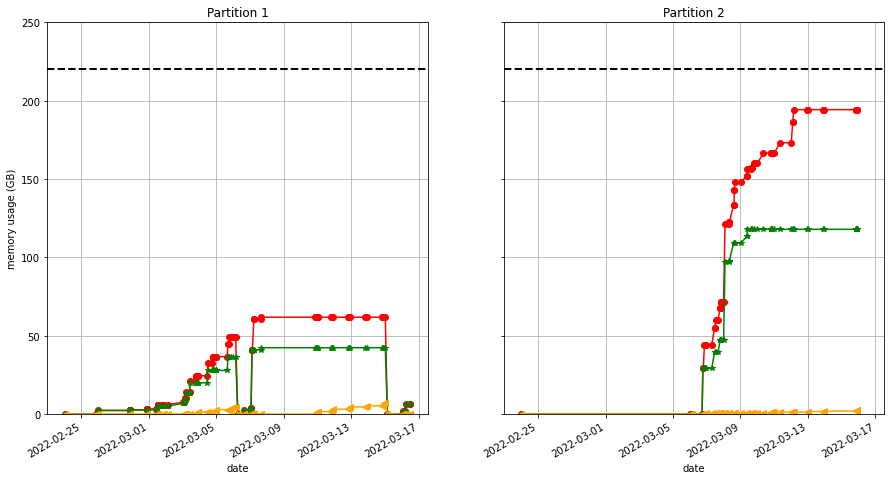

In [12]:
plot_tot(PHI)

## STP-194

In [13]:
i = 1
t0 = fromiso('2022-03-16T23:00:00')
hrt_focus = PHI_MODE('HRT')
kw = hrt_focus.observation(t0,71,cadence=0.5,shape=(2048,2048,1,1)); PHI.saving(i,**kw)

###################################
########## 2022-03-17 #############
###################################
fdt_SW = PHI_MODE('FDT')

hrt_NF31 = PHI_MODE('HRT')
hrt_NF32 = PHI_MODE('HRT')
kw = hrt_NF31.observation(fromiso('2022-03-17T00:18:00'),30,cadence=1,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = hrt_NF32.observation(fromiso('2022-03-17T03:18:00'),30,cadence=1,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = fdt_SW.observation(fromiso('2022-03-17T08:15:00'),1,cadence=1,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = hrt_NF31.cropping(kw['end']+tdelta(minutes=2),crop=[1024,1024],ndata=30,level='raw'); PHI.saving(i,**kw)
# kw = hrt_NF32.cropping(kw['end']+tdelta(minutes=2),crop=[1024,1024],ndata=30,level='raw'); PHI.saving(i,**kw)
kw = hrt_NF31.packing(kw['end']+tdelta(minutes=2),ndata=30,level='raw.crop'); PHI.saving(i,**kw)
kw = hrt_NF32.packing(kw['end']+tdelta(minutes=2),ndata=30,level='raw'); PHI.saving(i,**kw)


i = 1
kw = fdt_SW.observation(fromiso('2022-03-17T14:15:00'),1,cadence=1,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = fdt_SW.processing(kw['end']+tdelta(minutes=5),ndata=2,nout=3,level='raw'); PHI.saving(i,**kw)

i = 1
kw = fdt_SW.observation(fromiso('2022-03-17T20:15:00'),1,cadence=1,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = fdt_SW.processing(kw['end']+tdelta(minutes=5),ndata=1,nout=3,level='raw'); PHI.saving(i,**kw)


###################################
########## 2022-03-18 #############
###################################


i = 1
kw = fdt_SW.observation(fromiso('2022-03-18T02:15:00'),1,cadence=1,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = fdt_SW.processing(kw['end']+tdelta(minutes=5),ndata=1,nout=3,level='raw'); PHI.saving(i,**kw)

i = 1
kw = fdt_SW.observation(fromiso('2022-03-18T08:15:00'),1,cadence=1,shape=(2048,2048,4,6)); PHI.saving(i,**kw)

i = 1
hrt_SWb = PHI_MODE('HRT')
kw = hrt_SWb.observation(fromiso('2022-03-18T10:10:00'),12,cadence=5,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = hrt_SWb.packing(kw['end']+tdelta(minutes=5),ndata=12,level='raw'); PHI.saving(i,**kw)

i = 1
kw = fdt_SW.observation(fromiso('2022-03-18T13:45:00'),1,cadence=1,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = fdt_SW.processing(kw['end']+tdelta(minutes=5),ndata=2,nout=3,level='raw'); PHI.saving(i,**kw)

i = 1
kw = fdt_SW.observation(fromiso('2022-03-18T20:15:00'),1,cadence=1,shape=(2048,2048,4,6)); PHI.saving(i,**kw)

i = 2
kw = hrt_PO.compressing(fromiso('2022-03-18T20:25:00'),nbits=6,ndata=10,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(hrt_PO)
kw = hrt_PO.compressing(kw['end']+tdelta(minutes=5),nbits=6,ndata=7,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(hrt_PO)
i = 1
kw = fdt_SW.compressing(kw['end']+tdelta(minutes=1),nbits=6,ndata=3,level='proc'); PHI.saving(i,**kw)
print_flush_proc(fdt_SW)


###################################
########## 2022-03-19 #############
###################################


i = 1
kw = fdt_SW.observation(fromiso('2022-03-19T02:15:00'),1,cadence=1,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = fdt_SW.processing(kw['end']+tdelta(minutes=5),ndata=2,nout=3,level='raw'); PHI.saving(i,**kw)

i = 1
kw = fdt_SW.observation(fromiso('2022-03-19T08:15:00'),1,cadence=1,shape=(2048,2048,4,6)); PHI.saving(i,**kw)

i = 1
kw = hrt_SWb.observation(fromiso('2022-03-19T10:36:00'),12,cadence=5,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = hrt_SWb.packing(kw['end']+tdelta(minutes=5),ndata=12,level='raw'); PHI.saving(i,**kw)

i = 1
kw = fdt_SW.processing(kw['end']+tdelta(minutes=5),ndata=1,nout=5,level='raw'); PHI.saving(i,**kw)

i = 1
kw = fdt_SW.observation(fromiso('2022-03-19T14:15:00'),1,cadence=1,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = fdt_SW.processing(kw['end']+tdelta(minutes=5),ndata=1,nout=3,level='raw'); PHI.saving(i,**kw)

i = 1
kw = fdt_SW.observation(fromiso('2022-03-19T20:15:00'),1,cadence=1,shape=(2048,2048,4,6)); PHI.saving(i,**kw)

i = 2
kw = hrt_PO.compressing(fromiso('2022-03-19T20:25:00'),nbits=6,ndata=4,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(hrt_PO)

i = 1
kw = fdt_SW.compressing(kw['end']+tdelta(minutes=1),nbits=6,ndata=7,level='proc'); PHI.saving(i,**kw)
print_flush_proc(fdt_SW)


###################################
########## 2022-03-20 #############
###################################


i = 1
kw = fdt_SW.observation(fromiso('2022-03-20T02:15:00'),1,cadence=1,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = fdt_SW.processing(kw['end']+tdelta(minutes=5),ndata=2,nout=3,level='raw'); PHI.saving(i,**kw)

i = 1
kw = fdt_SW.observation(fromiso('2022-03-20T08:15:00'),1,cadence=1,shape=(2048,2048,4,6)); PHI.saving(i,**kw)

i = 1
kw = hrt_SWb.observation(fromiso('2022-03-20T11:27:00'),12,cadence=5,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = hrt_SWb.packing(kw['end']+tdelta(minutes=5),ndata=12,level='raw'); PHI.saving(i,**kw)

i = 1
kw = fdt_SW.observation(fromiso('2022-03-20T14:15:00'),1,cadence=1,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = fdt_SW.processing(kw['end']+tdelta(minutes=5),ndata=2,nout=3,level='raw'); PHI.saving(i,**kw)

i = 1
kw = fdt_SW.observation(fromiso('2022-03-20T20:15:00'),1,cadence=1,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = fdt_SW.processing(kw['end']+tdelta(minutes=5),ndata=1,nout=3,level='raw'); PHI.saving(i,**kw)

i = 2
kw = hrt_PO.compressing(fromiso('2022-03-20T21:45:00'),nbits=6,ndata=4,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(hrt_PO)
kw = fdt_SP.compressing(kw['end']+tdelta(minutes=1),nbits=6,ndata=1,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(fdt_SP)
i = 1
kw = fdt_SW.compressing(kw['end']+tdelta(minutes=1),nbits=6,ndata=3,level='proc'); PHI.saving(i,**kw)
print_flush_proc(fdt_SW)


###################################
########## 2022-03-21 #############
###################################



i = 1
kw = fdt_SW.observation(fromiso('2022-03-21T02:15:00'),1,cadence=1,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = fdt_SW.processing(kw['end']+tdelta(minutes=5),ndata=1,nout=3,level='raw'); PHI.saving(i,**kw)

i = 1
kw = fdt_SW.observation(fromiso('2022-03-21T08:15:00'),1,cadence=1,shape=(2048,2048,4,6)); PHI.saving(i,**kw)

i = 1
kw = hrt_SWb.observation(fromiso('2022-03-21T11:36:00'),12,cadence=5,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = hrt_SWb.packing(kw['end']+tdelta(minutes=5),ndata=12,level='raw'); PHI.saving(i,**kw)

i = 1
kw = fdt_SW.observation(fromiso('2022-03-21T14:10:00'),1,cadence=1,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = fdt_SW.processing(kw['end']+tdelta(minutes=25),ndata=2,nout=3,level='raw'); PHI.saving(i,**kw)

i = 1
kw = fdt_SW.observation(fromiso('2022-03-21T20:15:00'),1,cadence=1,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
fdt_PD1 = PHI_MODE('HRT')
kw = fdt_PD1.observation(fromiso('2022-03-21T20:17:00'),1,cadence=1,shape=(2048,2048,1,2)); PHI.saving(i,**kw)
kw = fdt_SW.processing(kw['end']+tdelta(minutes=5),ndata=1,nout=3,level='raw'); PHI.saving(i,**kw)
kw = fdt_PD1.packing(kw['end']+tdelta(minutes=5),ndata=1,level='raw'); PHI.saving(i,**kw)

i = 2
kw = hrt_PO.compressing(fromiso('2022-03-21T20:25:00'),nbits=6,ndata=4,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(hrt_PO)
i = 1
kw = fdt_SW.compressing(kw['end']+tdelta(minutes=1),nbits=6,ndata=6,level='proc'); PHI.saving(i,**kw)
print_flush_proc(fdt_SW)
kw = fdt_PD1.compressing(kw['end']+tdelta(minutes=1),nbits=6,ndata=1,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(fdt_PD1)


end of flushing 755.0 MB (10 datasets, 29/70): 2022-03-18T22:05:40
end of flushing 529.0 MB (7 datasets, 36/70): 2022-03-18T23:21:08
end of flushing 29.0 MB (3 datasets, 3/7): 2022-03-18T23:26:01
end of flushing 302.0 MB (4 datasets, 40/70): 2022-03-19T21:05:16
end of flushing 68.0 MB (7 datasets, 10/11): 2022-03-19T21:15:19
end of flushing 302.0 MB (4 datasets, 44/70): 2022-03-20T22:25:16
end of flushing 42.0 MB (1 datasets, 13/39): 2022-03-20T22:31:56
end of flushing 29.0 MB (3 datasets, 13/15): 2022-03-20T22:36:48
end of flushing 302.0 MB (4 datasets, 48/70): 2022-03-21T21:05:16
end of flushing 58.0 MB (6 datasets, 19/19): 2022-03-21T21:14:02
end of flushing 6.0 MB (1 datasets, 1/1): 2022-03-21T21:15:52


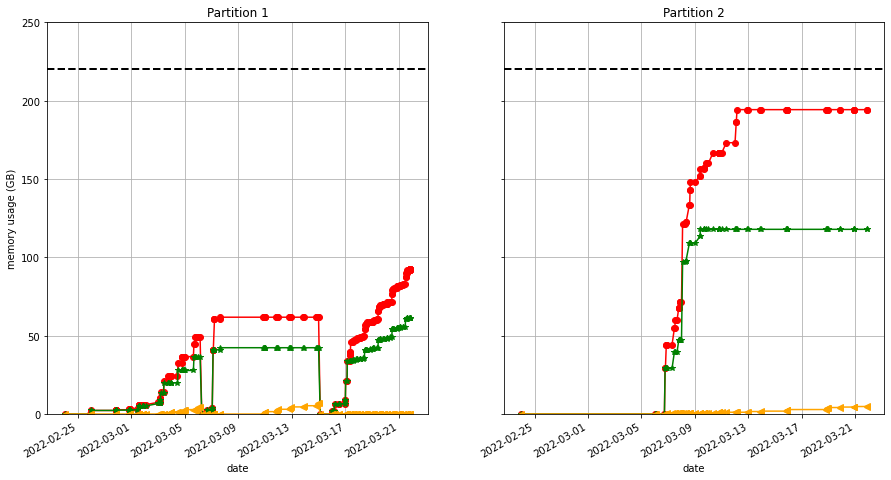

In [14]:
plot_tot(PHI)

## STP-195

In [15]:

###################################
########## 2022-03-22 #############
###################################

i = 1
kw = fdt_SW.observation(fromiso('2022-03-22T03:15:00'),1,cadence=1,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = fdt_SW.processing(kw['end']+tdelta(minutes=5),ndata=1,nout=3,level='raw'); PHI.saving(i,**kw)

i = 1
kw = hrt_focus.observation(fromiso('2022-03-22T07:30:00'),71,cadence=.5,shape=(2048,2048,1,1)); PHI.saving(i,**kw)
kw = hrt_SWb.observation(fromiso('2022-03-22T09:50:00'),20,cadence=10/6,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = hrt_PD1.observation(kw['end'],1,cadence=1,shape=(2048,2048,1,2)); PHI.saving(i,**kw)
# kw = hrt_flat.observation(kw['end'],9,cadence=7,shape=(2048,2048,4,6)); PHI.saving(i,**kw)

i = 1
kw = fdt_SW.observation(fromiso('2022-03-22T14:15:00'),1,cadence=1,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = hrt_SWb.packing(kw['end']+tdelta(minutes=5),ndata=20,level='raw'); PHI.saving(i,**kw)
kw = hrt_PD1.packing(kw['end']+tdelta(minutes=5),ndata=1,level='raw'); PHI.saving(i,**kw)

i = 1
kw = fdt_SW.observation(fromiso('2022-03-22T21:40:00'),1,cadence=1,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
# kw = hrt_flat.packing(kw['end']+tdelta(minutes=5),ndata=1,level='raw'); PHI.saving(i,**kw)

i = 2
kw = hrt_PO.compressing(fromiso('2022-03-22T20:25:00'),nbits=6,ndata=9,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(hrt_PO)
kw = fdt_SP.compressing(kw['end']+tdelta(minutes=1),nbits=6,ndata=1,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(fdt_SP)


###################################
########## 2022-03-23 #############
###################################

i = 1
kw = fdt_SW.observation(fromiso('2022-03-23T00:25:00'),1,cadence=1,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = fdt_focus.observation(fromiso('2022-03-23T00:27:00'),70,cadence=.5,shape=(2048,2048,1,1)); PHI.saving(i,**kw)

i = 1
kw = fdt_SW.observation(fromiso('2022-03-23T06:15:00'),1,cadence=1,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = fdt_SW.processing(kw['end']+tdelta(minutes=5),ndata=3,nout=3,level='raw'); PHI.saving(i,**kw)

i = 1
kw = fdt_SW.observation(fromiso('2022-03-23T12:15:00'),1,cadence=1,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = fdt_SW.processing(kw['end']+tdelta(minutes=5),ndata=2,nout=3,level='raw'); PHI.saving(i,**kw)

i = 1
kw = fdt_SW.observation(fromiso('2022-03-23T16:15:00'),1,cadence=1,shape=(2048,2048,4,6)); PHI.saving(i,**kw)

i = 2
kw = hrt_PO.compressing(fromiso('2022-03-23T18:00:00'),nbits=6,ndata=3,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(hrt_PO)
kw = hrt_HE.compressing(kw['end']+tdelta(minutes=2),nbits=6,ndata=7,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(hrt_HE)
kw = hrt_HE.compressing(kw['end']+tdelta(minutes=2),nbits=6,ndata=6,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(hrt_HE)
kw = fdt_SP.compressing(kw['end']+tdelta(minutes=2),nbits=6,ndata=6,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(fdt_SP)

i = 1
kw = hrt_NF31.compressing(kw['end']+tdelta(minutes=2),nbits=6,ndata=30,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(hrt_NF31)
kw = fdt_SW.compressing(kw['end']+tdelta(minutes=1),nbits=6,ndata=2,level='proc'); PHI.saving(i,**kw)
print_flush_proc(fdt_SW)


###################################
########## 2022-03-24 #############
###################################


i = 1
kw = fdt_SW.observation(fromiso('2022-03-24T00:25:00'),1,cadence=1,shape=(2048,2048,4,6)); PHI.saving(i,**kw)


i = 1
kw = fdt_SW.observation(fromiso('2022-03-24T06:15:00'),1,cadence=1,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = fdt_SW.processing(kw['end']+tdelta(minutes=5),ndata=3,nout=3,level='raw'); PHI.saving(i,**kw)

i = 1
kw = fdt_SW.observation(fromiso('2022-03-24T12:15:00'),1,cadence=1,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = fdt_SW.processing(kw['end']+tdelta(minutes=5),ndata=1,nout=3,level='raw'); PHI.saving(i,**kw)

i = 1
kw = fdt_SW.observation(fromiso('2022-03-24T16:15:00'),1,cadence=1,shape=(2048,2048,4,6)); PHI.saving(i,**kw)

i = 1
kw = hrt_NF32.compressing(fromiso('2022-03-24T18:00:00'),nbits=6,ndata=10,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(hrt_NF32)
kw = hrt_NF32.compressing(kw['end']+tdelta(minutes=2),nbits=6,ndata=10,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(hrt_NF32)
kw = hrt_NF32.compressing(kw['end']+tdelta(minutes=2),nbits=6,ndata=6,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(hrt_NF32)

kw = fdt_SW.compressing(kw['end']+tdelta(minutes=1),nbits=6,ndata=6,level='proc'); PHI.saving(i,**kw)
print_flush_proc(fdt_SW)


###################################
########## 2022-03-25 #############
###################################


i = 1
kw = fdt_SW.observation(fromiso('2022-03-25T00:25:00'),1,cadence=1,shape=(2048,2048,4,6)); PHI.saving(i,**kw)

i = 1
kw = fdt_SW.observation(fromiso('2022-03-25T06:15:00'),1,cadence=1,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = fdt_SW.processing(kw['end']+tdelta(minutes=5),ndata=3,nout=3,level='raw'); PHI.saving(i,**kw)

i = 1
kw = fdt_SW.observation(fromiso('2022-03-25T12:15:00'),1,cadence=1,shape=(2048,2048,4,6)); PHI.saving(i,**kw)

i = 1
kw = fdt_SW.observation(fromiso('2022-03-25T16:15:00'),1,cadence=1,shape=(2048,2048,4,6)); PHI.saving(i,**kw)

i = 2
kw = hrt_NF2.compressing(fromiso('2022-03-25T18:00:00'),nbits=6,ndata=40,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(hrt_NF2)
kw = hrt_NF2.compressing(kw['end']+tdelta(minutes=2),nbits=6,ndata=40,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(hrt_NF2)
kw = hrt_NF2.compressing(kw['end']+tdelta(minutes=2),nbits=6,ndata=30,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(hrt_NF2)

i = 1
kw = hrt_NF32.compressing(kw['end']+tdelta(minutes=2),nbits=6,ndata=4,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(hrt_NF32)
kw = fdt_SW.compressing(kw['end']+tdelta(minutes=1),nbits=6,ndata=2,level='proc'); PHI.saving(i,**kw)
print_flush_proc(fdt_SW)


###################################
########## 2022-03-26 #############
###################################


i = 1
kw = fdt_SW.observation(fromiso('2022-03-26T00:25:00'),1,cadence=1,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = fdt_SW.processing(kw['end']+tdelta(minutes=5),ndata=2,nout=3,level='raw'); PHI.saving(i,**kw)

i = 1
kw = fdt_SW.observation(fromiso('2022-03-26T06:15:00'),1,cadence=1,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = fdt_SW.processing(kw['end']+tdelta(minutes=5),ndata=2,nout=3,level='raw'); PHI.saving(i,**kw)

i = 1
kw = fdt_SW.observation(fromiso('2022-03-26T12:15:00'),1,cadence=1,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = fdt_PD1.observation(fromiso('2022-03-26T12:18:00'),1,cadence=1,shape=(2048,2048,1,2)); PHI.saving(i,**kw)
kw = fdt_PD1.packing(fromiso('2022-03-26T12:21:00'),ndata=1,level='raw'); PHI.saving(i,**kw)
kw = fdt_SW.packing(kw['end']+tdelta(minutes=5),ndata=1,level='raw'); PHI.saving(i,**kw)

i = 1
kw = fdt_SW.observation(fromiso('2022-03-26T16:15:00'),1,cadence=1,shape=(2048,2048,4,6)); PHI.saving(i,**kw)

i = 2
kw = hrt_NF2.compressing(fromiso('2022-03-26T18:00:00'),nbits=6,ndata=10,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(hrt_NF2)
kw = fdt_SP.compressing(kw['end']+tdelta(minutes=2),nbits=6,ndata=10,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(fdt_SP)

i = 1
kw = hrt_SWb.compressing(kw['end']+tdelta(minutes=2),nbits=6,ndata=6,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(hrt_SWb)
kw = hrt_SWb.compressing(kw['end']+tdelta(minutes=2),nbits=6,ndata=6,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(hrt_SWb)
kw = hrt_SWb.compressing(kw['end']+tdelta(minutes=2),nbits=6,ndata=2,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(hrt_SWb)
kw = fdt_SW.compressing(kw['end']+tdelta(minutes=1),nbits=6,ndata=1,level='proc'); PHI.saving(i,**kw)
print_flush_proc(fdt_SW)


###################################
########## 2022-03-27 #############
###################################


i = 1
kw = fdt_SW.observation(fromiso('2022-03-27T00:25:00'),1,cadence=1,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = fdt_SW.processing(kw['end']+tdelta(minutes=5),ndata=1,nout=3,level='raw'); PHI.saving(i,**kw)

i = 1
kw = fdt_SW.observation(fromiso('2022-03-27T06:15:00'),1,cadence=1,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = fdt_SW.processing(kw['end']+tdelta(minutes=5),ndata=2,nout=3,level='raw'); PHI.saving(i,**kw)

i = 1
kw = fdt_SW.observation(fromiso('2022-03-27T12:15:00'),1,cadence=1,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = fdt_SW.processing(kw['end']+tdelta(minutes=5),ndata=1,nout=3,level='raw'); PHI.saving(i,**kw)

i = 1
kw = fdt_SW.observation(fromiso('2022-03-27T16:15:00'),1,cadence=1,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = fdt_SW.processing(kw['end']+tdelta(minutes=5),ndata=1,nout=3,level='raw'); PHI.saving(i,**kw)

i = 1
kw = hrt_SWb.compressing(fromiso('2022-03-27T18:00:00'),nbits=6,ndata=10,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(hrt_SWb)
kw = hrt_SWb.compressing(kw['end']+tdelta(minutes=2),nbits=6,ndata=10,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(hrt_SWb)
kw = hrt_SWb.compressing(kw['end']+tdelta(minutes=2),nbits=6,ndata=2,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(hrt_SWb)
kw = hrt_SWb.compressing(kw['end']+tdelta(minutes=2),nbits=6,ndata=4,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(hrt_SWb)


kw = fdt_SW.compressing(kw['end']+tdelta(minutes=1),nbits=6,ndata=6,level='proc'); PHI.saving(i,**kw)
print_flush_proc(fdt_SW)



###################################
########## 2022-03-28 #############
###################################


i = 1
kw = fdt_SW.observation(fromiso('2022-03-28T00:25:00'),1,cadence=1,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = fdt_SW.processing(kw['end']+tdelta(minutes=5),ndata=1,nout=3,level='raw'); PHI.saving(i,**kw)

i = 1
kw = fdt_SW.observation(fromiso('2022-03-28T06:15:00'),1,cadence=1,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = fdt_SW.processing(kw['end']+tdelta(minutes=5),ndata=1,nout=3,level='raw'); PHI.saving(i,**kw)

i = 1
kw = fdt_SW.observation(fromiso('2022-03-28T12:15:00'),1,cadence=1,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = fdt_SW.processing(kw['end']+tdelta(minutes=5),ndata=1,nout=3,level='raw'); PHI.saving(i,**kw)

i = 1
kw = fdt_SW.observation(fromiso('2022-03-28T16:15:00'),1,cadence=1,shape=(2048,2048,4,6)); PHI.saving(i,**kw)

i = 1
kw = hrt_SWb.compressing(fromiso('2022-03-28T18:00:00'),nbits=6,ndata=8,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(hrt_SWb)
kw = hrt_SWb.compressing(kw['end']+tdelta(minutes=2),nbits=6,ndata=2,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(hrt_SWb)
kw = hrt_SWb.compressing(kw['end']+tdelta(minutes=2),nbits=6,ndata=10,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(hrt_SWb)
kw = hrt_SWb.compressing(kw['end']+tdelta(minutes=2),nbits=6,ndata=2,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(hrt_SWb)
kw = fdt_PD1.compressing(kw['end']+tdelta(minutes=2),nbits=6,ndata=1,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(fdt_PD1)
kw = fdt_flat.compressing(kw['end']+tdelta(minutes=2),nbits=6,ndata=1,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(fdt_PD1)

kw = fdt_SW.compressing(kw['end']+tdelta(minutes=1),nbits=6,ndata=3,level='proc'); PHI.saving(i,**kw)
print_flush_proc(fdt_SW)

i = 2
kw = hrt_PO.compressing(kw['end']+tdelta(minutes=2),nbits=6,ndata=6,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(hrt_PO)



end of flushing 680.0 MB (9 datasets, 57/70): 2022-03-22T21:55:36
end of flushing 42.0 MB (1 datasets, 14/39): 2022-03-22T22:02:16
end of flushing 227.0 MB (3 datasets, 60/70): 2022-03-23T18:30:12
end of flushing 529.0 MB (7 datasets, 12/18): 2022-03-23T19:42:40
end of flushing 453.0 MB (6 datasets, 18/18): 2022-03-23T20:45:04
end of flushing 255.0 MB (6 datasets, 20/39): 2022-03-23T21:21:03
end of flushing 567.0 MB (30 datasets, 30/30): 2022-03-23T22:38:35
end of flushing 19.0 MB (2 datasets, 21/26): 2022-03-23T22:42:11
end of flushing 755.0 MB (10 datasets, 10/30): 2022-03-24T19:40:40
end of flushing 755.0 MB (10 datasets, 20/30): 2022-03-24T21:23:21
end of flushing 453.0 MB (6 datasets, 26/30): 2022-03-24T22:25:45
end of flushing 58.0 MB (6 datasets, 27/30): 2022-03-24T22:34:31
end of flushing 755.0 MB (40 datasets, 40/120): 2022-03-25T19:40:42
end of flushing 755.0 MB (40 datasets, 80/120): 2022-03-25T21:23:25
end of flushing 567.0 MB (30 datasets, 110/120): 2022-03-25T22:40:57
end

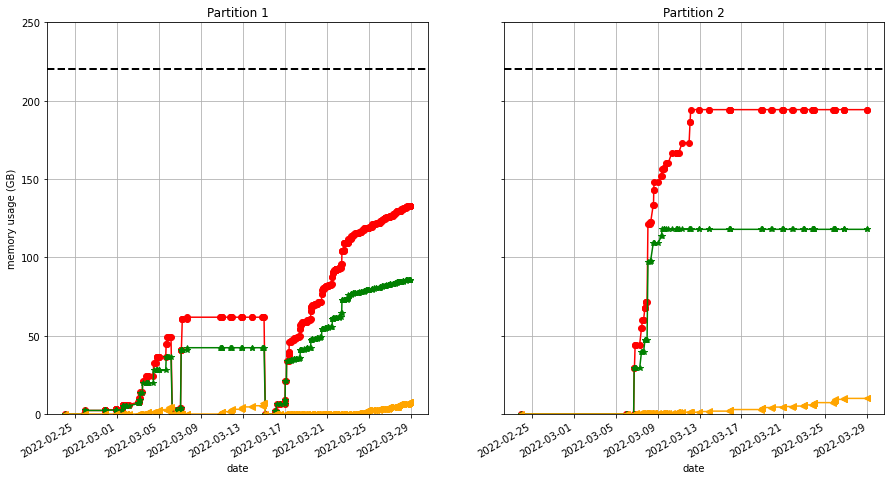

In [16]:
plot_tot(PHI)

## STP-196

In [17]:
###################################
########## 2022-03-29 #############
###################################

PHI.format_partition(2,fromiso('2022-03-29T00:15:00'))

i = 1
kw = fdt_SW.observation(fromiso('2022-03-29T03:30:00'),1,cadence=1,shape=(2048,2048,4,6)); PHI.saving(i,**kw)

kw = fdt_SW.observation(fromiso('2022-03-29T09:30:00'),1,cadence=1,shape=(2048,2048,4,6)); PHI.saving(i,**kw)


i = 2
kw = hrt_flat.observation(fromiso('2022-03-29T10:54:00'),10,cadence=50,shape=(2048,2048,4,6)); PHI.saving(i,**kw)

i = 1
kw = fdt_SW.observation(fromiso('2022-03-29T22:15:00'),1,cadence=1,shape=(2048,2048,4,6)); PHI.saving(i,**kw)


###################################
########## 2022-03-30 #############
###################################

i = 2
hrt_NF4 = PHI_MODE('HRT')
kw = hrt_NF4.observation(fromiso('2022-03-30T00:18:00'),18,cadence=100/60,shape=(2048,2048,4,6)); PHI.saving(i,**kw)

hrt_PO2 = PHI_MODE('HRT')
kw = hrt_PO2.observation(fromiso('2022-03-30T03:30:00'),32,cadence=130/60,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = hrt_PO2.observation(fromiso('2022-03-30T04:40:00'),13,cadence=100/60,shape=(2048,2048,4,6)); PHI.saving(i,**kw)

i = 1
kw = fdt_SW.processing(kw['end']+tdelta(minutes=5),ndata=2,nout=3,level='raw'); PHI.saving(i,**kw)

kw = fdt_SW.compressing(kw['end']+tdelta(minutes=1),nbits=6,ndata=3,level='proc'); PHI.saving(i,**kw)
print_flush_proc(fdt_SW)

i = 2
kw = hrt_flat.packing(kw['end']+tdelta(minutes=2),ndata=2,level='raw'); PHI.saving(i,**kw)
kw = hrt_flat.compressing(kw['end']+tdelta(minutes=1),nbits=6,ndata=1,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(hrt_flat)

hrt_CM2 = PHI_MODE('HRT')
kw = hrt_CM2.observation(fromiso('2022-03-30T09:00:00'),12,cadence=80,shape=(2048,2048,4,6)); PHI.saving(i,**kw)


###################################
########## 2022-03-31 #############
###################################

PHI.format_partition(1,fromiso('2022-03-31T00:15:00'))

i = 2
kw = hrt_CM2.observation(fromiso('2022-03-31T03:50:00'),11,cadence=80,shape=(2048,2048,4,6)); PHI.saving(i,**kw)


i = 1
hrt_AR = PHI_MODE('HRT')
kw = hrt_AR.observation(fromiso('2022-03-31T17:56:00'),6+7,cadence=30,shape=(2048,1152,4,6)); PHI.saving(i,**kw)


###################################
########## 2022-04-01 #############
###################################

i = 1
kw = hrt_AR.observation(fromiso('2022-04-01T00:26:00'),6+6+6+6+6+6+6+6,cadence=30,shape=(2048,1152,4,6)); PHI.saving(i,**kw)


###################################
########## 2022-04-02 #############
###################################

i = 1
kw = hrt_AR.observation(fromiso('2022-04-02T03:26:00'),6+6+6+6+6+6+6,cadence=30,shape=(2048,1152,4,6)); PHI.saving(i,**kw)

###################################
########## 2022-04-03 #############
###################################

i = 1
kw = hrt_AR.observation(fromiso('2022-04-03T00:26:00'),6+6+6+6+6+6+6+6,cadence=30,shape=(2048,1152,4,6)); PHI.saving(i,**kw)

###################################
########## 2022-04-04 #############
###################################

i = 1
kw = hrt_AR.observation(fromiso('2022-04-04T03:26:00'),6+6+6+6+1,cadence=30,shape=(2048,1152,4,6)); PHI.saving(i,**kw)

hrt_focus = PHI_MODE('HRT')
kw = hrt_focus.observation(kw['end']+tdelta(minutes=10),71,cadence=.5,shape=(2048,2048,1,1)); PHI.saving(i,**kw)

i = 2
hrt_PO3 = PHI_MODE('HRT')
kw = hrt_PO3.observation(fromiso('2022-04-04T16:45:00'),3+6+6,cadence=30,shape=(2048,2048,4,6)); PHI.saving(i,**kw)


###################################
########## 2022-04-05 #############
###################################

i = 2
kw = hrt_PO3.observation(fromiso('2022-04-05T00:15:00'),6+6+6+6+6+6,cadence=30,shape=(2048,2048,4,6)); PHI.saving(i,**kw)


end of flushing 29.0 MB (3 datasets, 42/49): 2022-03-30T06:21:32
end of flushing 76.0 MB (1 datasets, 3/31): 2022-03-30T06:37:24


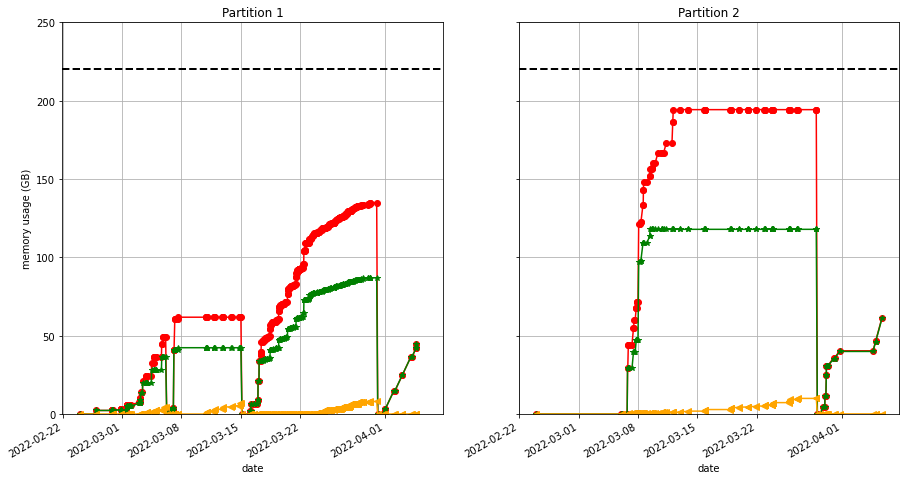

In [18]:
plot_tot(PHI)

## STP-197

In [19]:
###################################
########## 2022-04-06 #############
###################################

i = 2
kw = hrt_NF4.packing(fromiso('2022-04-06T00:35:00'),ndata=18,level='raw'); PHI.saving(i,**kw)

i = 1
kw = hrt_AR.cropping(kw['end'] + tdelta(minutes=2),crop=[1152,1152],ndata=13,level='raw'); PHI.saving(i,**kw)
kw = hrt_AR.packing(kw['end'] + tdelta(minutes=2),ndata=13,level='raw.crop'); PHI.saving(i,**kw)
kw = hrt_AR.cropping(kw['end'] + tdelta(minutes=2),crop=[1152,1152],ndata=48,level='raw'); PHI.saving(i,**kw)
kw = hrt_AR.packing(kw['end'] + tdelta(minutes=2),ndata=48,level='raw.crop'); PHI.saving(i,**kw)

fdt_focus = PHI_MODE('FDT')
kw = fdt_focus.observation(kw['end']+tdelta(minutes=10),70,cadence=.5,shape=(2048,2048,1,1)); PHI.saving(i,**kw)

kw = fdt_flat.observation(fromiso('2022-04-06T10:00:00'),9,cadence=6,shape=(2048,2048,4,6)); PHI.saving(i,**kw)

i = 2
kw = hrt_AR.compressing(kw['end']+tdelta(minutes=1),nbits=6,ndata=2,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(hrt_AR)

kw = hrt_flat.observation(fromiso('2022-04-06T13:00:00'),10,cadence=50,shape=(2048,2048,4,6)); PHI.saving(i,**kw)


###################################
########## 2022-04-07 #############
###################################

i = 1
kw = fdt_flat.observation(fromiso('2022-04-07T00:30:00'),1,cadence=6,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = hrt_flat.observation(fromiso('2022-04-07T07:30:00'),1,cadence=6,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = fdt_flat.packing(fromiso('2022-04-07T08:30:00'),ndata=1,level='raw'); PHI.saving(i,**kw)
kw = hrt_flat.packing(kw['end'] + tdelta(minutes=2),ndata=1,level='raw'); PHI.saving(i,**kw)

kw = hrt_flat.observation(fromiso('2022-04-07T10:00:00'),9,cadence=6,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = hrt_flat.observation(fromiso('2022-04-07T10:00:00'),1,cadence=6,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
hrt_test = PHI_MODE('HRT')
kw = hrt_test.observation(fromiso('2022-04-07T10:00:00'),1,cadence=6,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = hrt_flat.packing(fromiso('2022-04-07T17:30:00'),ndata=1,level='raw'); PHI.saving(i,**kw)
kw = hrt_test.processing(kw['end'] + tdelta(minutes=2),ndata=1,nout=5,level='raw'); PHI.saving(i,**kw)


###################################
########## 2022-04-08 #############
###################################

i = 1
kw = hrt_flat.compressing(fromiso('2022-04-08T00:10:00'),nbits=6,ndata=1,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(hrt_flat)
kw = hrt_test.compressing(kw['end'] + tdelta(minutes=2),nbits=6,ndata=1,level='proc'); PHI.saving(i,**kw)
print_flush_proc(hrt_test)
kw = fdt_flat.compressing(kw['end'] + tdelta(minutes=2),nbits=6,ndata=1,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(fdt_flat)

i = 2
kw = hrt_AR.compressing(kw['end']+tdelta(minutes=1),nbits=6,ndata=1,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(hrt_AR)

i = 1
syn = PHI_MODE('FDT')
kw = syn.observation(fromiso('2022-04-08T03:15:00'),1,cadence=2,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = syn.observation(fromiso('2022-04-08T09:00:00'),1,cadence=2,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = syn.observation(fromiso('2022-04-08T15:00:00'),1,cadence=2,shape=(2048,2048,4,6)); PHI.saving(i,**kw)

kw = syn.processing(kw['end']+tdelta(minutes=5),ndata=3,nout=3,level='raw'); PHI.saving(i,**kw)

kw = syn.observation(fromiso('2022-04-08T21:00:00'),1,cadence=2,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = syn.processing(kw['end']+tdelta(minutes=5),ndata=1,nout=3,level='raw'); PHI.saving(i,**kw)


###################################
########## 2022-04-09 #############
###################################

i = 1
kw = syn.compressing(kw['end']+tdelta(minutes=1),nbits=6,ndata=4,level='proc'); PHI.saving(i,**kw)
print_flush_proc(syn)

kw = syn.observation(fromiso('2022-04-09T03:00:00'),1,cadence=2,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = syn.observation(fromiso('2022-04-09T09:00:00'),1,cadence=2,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = syn.observation(fromiso('2022-04-09T15:00:00'),1,cadence=2,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = syn.processing(kw['end']+tdelta(minutes=5),ndata=3,nout=3,level='raw'); PHI.saving(i,**kw)

kw = syn.observation(fromiso('2022-04-09T21:00:00'),1,cadence=2,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = syn.processing(kw['end']+tdelta(minutes=5),ndata=1,nout=3,level='raw'); PHI.saving(i,**kw)


###################################
########## 2022-04-10 #############
###################################

i = 1
kw = syn.compressing(kw['end']+tdelta(minutes=1),nbits=6,ndata=4,level='proc'); PHI.saving(i,**kw)
print_flush_proc(syn)
kw = hrt_AR.compressing(kw['end']+tdelta(minutes=1),nbits=6,ndata=10,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(hrt_AR)
kw = hrt_AR.compressing(kw['end']+tdelta(minutes=1),nbits=6,ndata=5,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(hrt_AR)

i = 2
kw = hrt_NF4.compressing(kw['end']+tdelta(minutes=1),nbits=6,ndata=8,level='raw.pack'); PHI.saving(i,**kw)
print_flush_pack(hrt_NF4)

i = 1
kw = syn.observation(fromiso('2022-04-10T03:00:00'),1,cadence=2,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = syn.observation(fromiso('2022-04-10T09:00:00'),1,cadence=2,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = syn.observation(fromiso('2022-04-10T15:00:00'),1,cadence=2,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = syn.processing(kw['end']+tdelta(minutes=5),ndata=3,nout=3,level='raw'); PHI.saving(i,**kw)

kw = syn.observation(fromiso('2022-04-10T21:00:00'),1,cadence=2,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = syn.processing(kw['end']+tdelta(minutes=5),ndata=1,nout=3,level='raw'); PHI.saving(i,**kw)


end of flushing 48.0 MB (2 datasets, 2/176): 2022-04-06T11:01:22
end of flushing 76.0 MB (1 datasets, 4/52): 2022-04-08T00:20:04
end of flushing 16.0 MB (1 datasets, 1/1): 2022-04-08T00:24:13
end of flushing 76.0 MB (1 datasets, 2/20): 2022-04-08T00:36:17
end of flushing 24.0 MB (1 datasets, 3/176): 2022-04-08T00:40:28
end of flushing 39.0 MB (4 datasets, 4/4): 2022-04-08T21:48:10
end of flushing 39.0 MB (4 datasets, 8/8): 2022-04-09T21:48:10
end of flushing 239.0 MB (10 datasets, 13/176): 2022-04-09T22:21:02
end of flushing 119.0 MB (5 datasets, 18/176): 2022-04-09T22:37:58
end of flushing 604.0 MB (8 datasets, 8/18): 2022-04-09T23:59:30


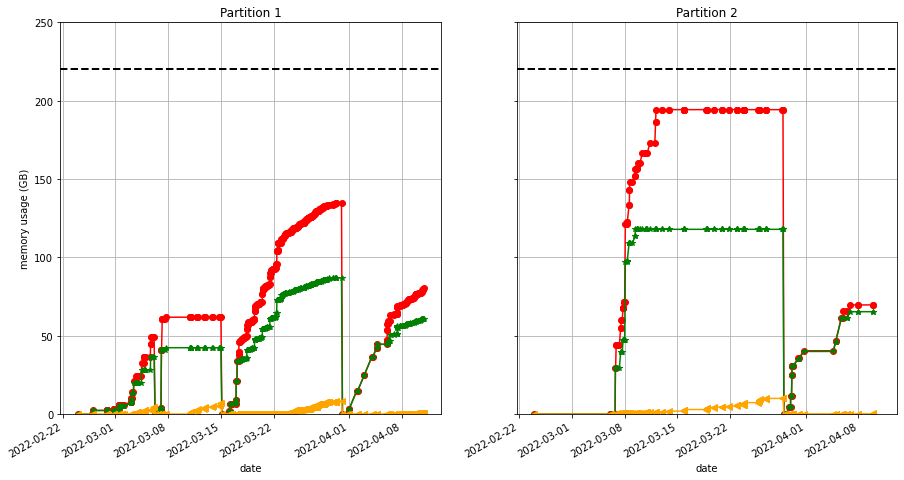

In [20]:
plot_tot(PHI)

# <span style="color:red">Database Test (for DID check)</span>

In [190]:
"""
import pandas as pd
def add_0(s,l = 2):
    if type(s) == int:
        s = str(s)
    if len(s)<l:
        for i in range(l-len(s)):
            s = '0'+s
    return s

t0 = fromiso('2022-01-20T00:00:00')
n = 720
did = add_0(str(t0.year-2020))+add_0(str(t0.month))+add_0(str(t0.day))
did = did + '0000'
did_int = int(did)
d = {'raw':[add_0(did_int+i,10) for i in range(n)],
    'crop':['0' for i in range(n)],
    'pack':['0' for i in range(n)],
    'proc':['0' for i in range(n)],
    'flush':['0' for i in range(n)]}
index = pd.MultiIndex.from_tuples([(t0,i+1) for i in range(n)])
df = pd.DataFrame(d,index=index)
df.index.names = ['date','i']
""";


# d = {'raw':['0201200000','0201201000'],'crop':['',''],'pack':['',''],'proc':['','']}
# d = {'raw':['0201200000'],'crop':['0'],'pack':['0'],'proc':['0'],'flush':['0']}
# index = pd.MultiIndex.from_tuples([(t0,0)])

# t0 = fromiso('2022-01-20T12:02:00')
# n = 720
# did = add_0(str(t0.year-2020))+add_0(str(t0.month))+add_0(str(t0.day))
# if ~np.any(df.raw.str.contains(pat = '020120')):
#     did = did + '0000'
#     did_int = int(did)
#     d = {'raw':[add_0(did_int+i) for i in range(n)],
#         'crop':['0' for i in range(n)],
#         'pack':['0' for i in range(n)],
#         'proc':['0' for i in range(n)],
#         'flush':['0' for i in range(n)]}
#     index = pd.MultiIndex.from_tuples([(t0,i+1) for i in range(n)])
# df_temp = pd.DataFrame(d,index=index)
# df_temp.index.names = ['date','i']
# df = df.append(df_temp)
# df
# np.any(df.raw.str.contains(pat = '020120'))
